# Practice with the Tensorflow 2 Functional API. 

> In this post, it will demonstrate how to build models with the Functional syntax. You'll build one using the Sequential API and see how you can do the same with the Functional API. Both will arrive at the same architecture and you can train and evaluate it as usual. This is the summary of lecture "Custom Models, Layers and Loss functions with Tensorflow" from DeepLearning.AI.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow, DeepLearning.AI]
- image: images/fashion_mnist_siamese.png

## Packages

In [38]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image, ImageFont, ImageDraw
import itertools
import random

## Part 1 - Comparing Functional API with Sequential API

### Prepare the Data

We will use mnist dataset for the check.

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

### Sequential API

Here is how we use the `Sequential()` class to build a model.

In [3]:
def build_model_with_sequential():
    # instantiate a Sequential class and linearly stack the layers of your model
    seq_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    return seq_model

### Functional API

And here is how you build the same model above with the functional syntax.

In [4]:
def build_model_wtih_functional():
    # instantiate the input Tensor
    input_layer = tf.keras.Input(shape=(28, 28))
    
    # stack the layers using the syntax: new_layer()(previous_layer)
    flatten_layer = tf.keras.layers.Flatten()(input_layer)
    first_dense = tf.keras.layers.Dense(128, activation=tf.nn.relu)(flatten_layer)
    output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(first_dense)
    
    # declare inputs and outputs
    func_model = Model(inputs=input_layer, outputs=output_layer)
    return func_model

### Build the model and visualize the model graph

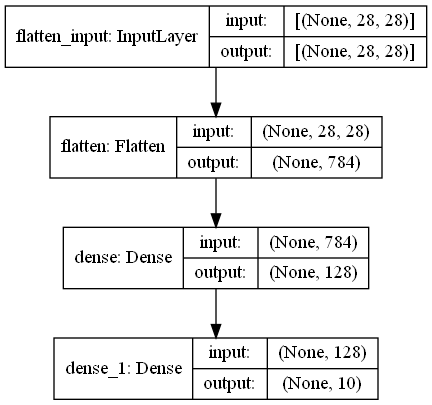

In [5]:
model = build_model_with_sequential()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/sequential_model.png')

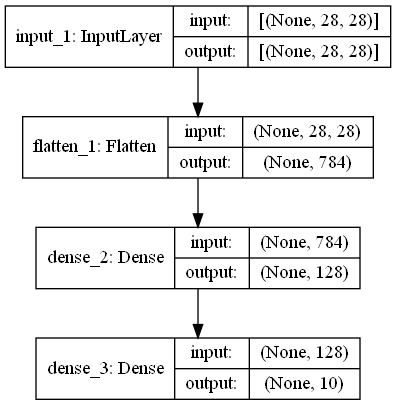

In [6]:
model = build_model_wtih_functional()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/functional_model.png')

You can see that both model has same architecture.

### Training the model

Regardless if you built it with the Sequential or Functional API, you'll follow the same steps when training and evaluating your model.

In [7]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2587 - accuracy: 0.9260
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1154 - accuracy: 0.9660
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0790 - accuracy: 0.9762
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0582 - accuracy: 0.9820
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0455 - accuracy: 0.9862


In [8]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0805 - accuracy: 0.9743


[0.08054833114147186, 0.9743000268936157]

## Part 2 - Build a Multi-output Model

In this section, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load.

### Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [9]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])

def plot_metrics(history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

### Prepare the Data

We download the dataset and format it for training.

In [10]:
# Specify data URI
URI = './dataset/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df.dropna(axis=1, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the train and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [12]:
df.head()

X1     X2     X3     X4   X5  X6    X7  X8     Y1     Y2
0  0.74  686.0  245.0  220.5  3.5   4  0.40   2  14.18  16.99
1  0.90  563.5  318.5  122.5  7.0   5  0.00   0  19.68  29.60
2  0.64  784.0  343.0  220.5  3.5   2  0.10   5  15.16  19.24
3  0.71  710.5  269.5  220.5  3.5   2  0.10   2  10.64  13.67
4  0.90  563.5  318.5  122.5  7.0   5  0.25   2  31.66  37.72

### Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [13]:
# define model layers
input_layer = Input(shape=(len(train.columns), ))
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          16512       dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           8256        dense_5[0][0]                    
____________________________________________________________________________________________

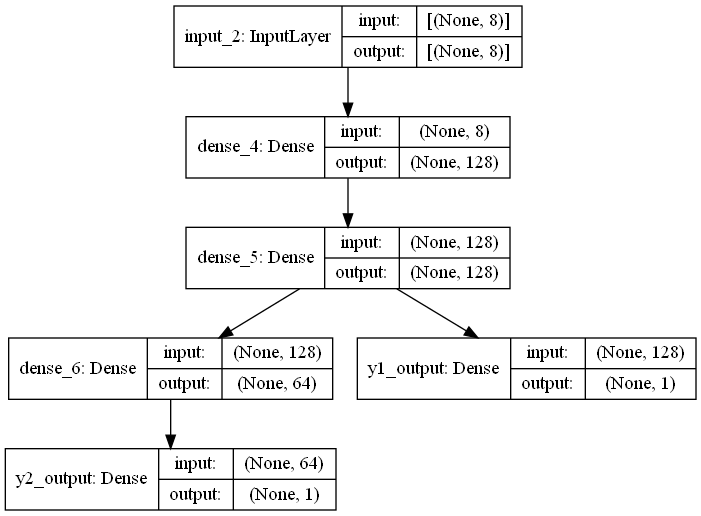

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/multi_output_model.png')

### Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [16]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={
                  'y1_output':'mse',
                  'y2_output':'mse'
              },
             metrics={
                 'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                 'y2_output':tf.keras.metrics.RootMeanSquaredError()
             })

### Train the Model

In [17]:
# train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y), verbose=0)

### Evaluate the Model and Plot Metrics

In [18]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 4ms/step - loss: 0.6642 - y1_output_loss: 0.1839 - y2_output_loss: 0.4802 - y1_output_root_mean_squared_error: 0.4289 - y2_output_root_mean_squared_error: 0.6930
Loss = 0.6641601920127869, Y1_loss = 0.183916375041008, Y1_mse = 0.42885470390319824, Y2_loss = 0.4802437722682953, Y2_mse = 0.6929962038993835


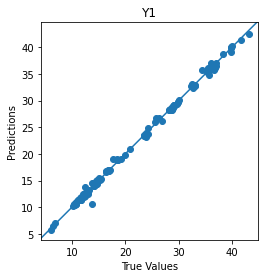

In [19]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')

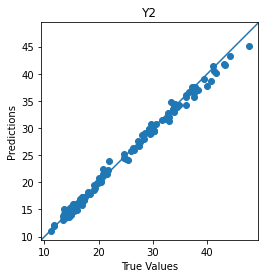

In [20]:
plot_diff(test_Y[1], Y_pred[1], title='Y2')

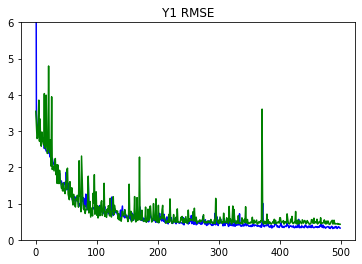

In [21]:
plot_metrics(history, metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)

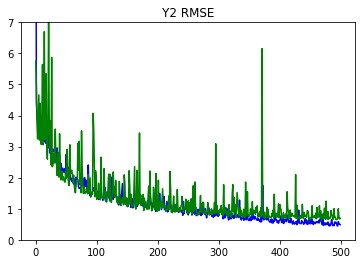

In [22]:
plot_metrics(history, metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)

## Part 3 - Implement a Siamese Network

In this section, it will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing.

### Prepare the Dataset

First define a few utilities for preparing and visualizing your dataset.

In [23]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

You can now download and prepare our train and test sets. You will also create pairs of images that will go into the multi-input model.

In [24]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
train_pairs, train_y = create_pairs_on_set(train_images, train_labels)
test_pairs, test_y = create_pairs_on_set(test_images, test_labels)

You can see a sample pair of images below.

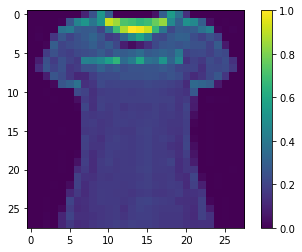

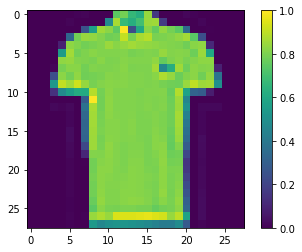

1.0


In [25]:
# array index
this_pair = 8

# show images at this index
show_image(test_pairs[this_pair][0])
show_image(test_pairs[this_pair][1])

# print the label for this pair
print(test_y[this_pair])

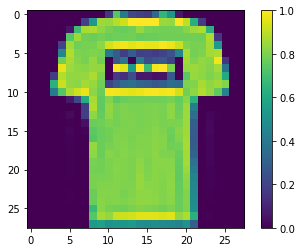

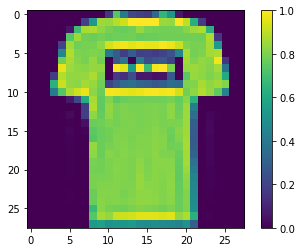

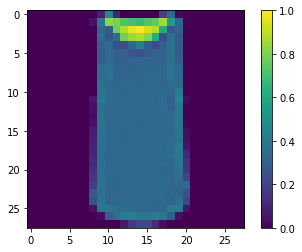

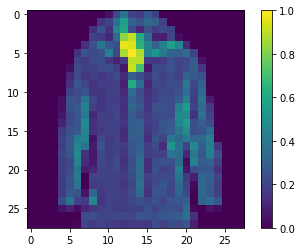

In [26]:
# print other pairs

show_image(train_pairs[:,0][0])
show_image(train_pairs[:,0][1])

show_image(train_pairs[:,1][0])
show_image(train_pairs[:,1][1])

### Build the Model

Next, you'll define some utilities for building our model.

In [27]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

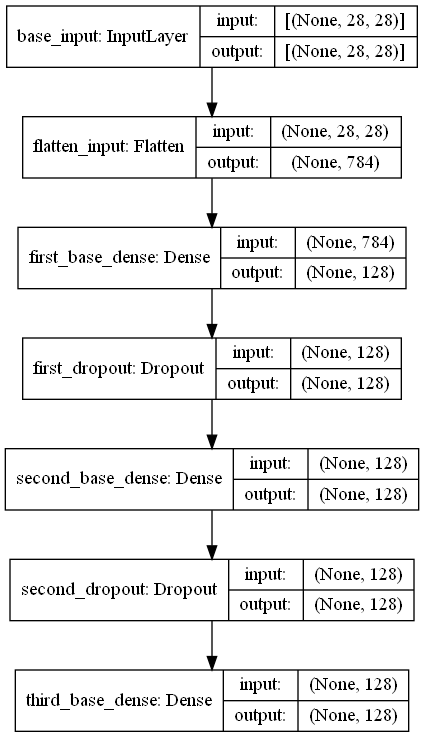

In [28]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='./image/base-siamese-model.png')

Let's now build the Siamese network. The plot will show two inputs going to the base network.

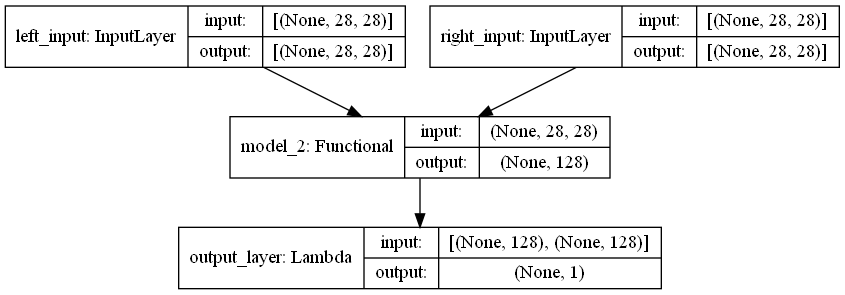

In [29]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/outer-siamese-model.png')

### Train the Model

You can now define the custom loss for our network and start training.

In [30]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''
        Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [31]:
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=RMSprop())
history = model.fit([train_pairs[:,0], train_pairs[:,1]], train_y, epochs=20, batch_size=128, validation_data=([test_pairs[:,0], test_pairs[:,1]], test_y))

Epoch 1/20
938/938 [==============================] - 8s 8ms/step - loss: 0.1115 - val_loss: 0.0827
Epoch 2/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0791 - val_loss: 0.0760
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0703 - val_loss: 0.0707
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0658 - val_loss: 0.0664
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0628 - val_loss: 0.0651
Epoch 6/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0606 - val_loss: 0.0653
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0590 - val_loss: 0.0654
Epoch 8/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0579 - val_loss: 0.0678
Epoch 9/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0565 - val_loss: 0.0632
Epoch 10/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0559 - val_loss: 0.0636

### Model Evaluation

As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.

In [32]:
def compute_accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [33]:
loss = model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_y)

y_pred_train = model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_y, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_y, y_pred_test)

625/625 [==============================] - 1s 2ms/step - loss: 0.0639


In [34]:
print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

Loss = 0.06388980895280838, Train Accuracy = 0.9388898149691616 Test Accuracy = 0.9131631631631631


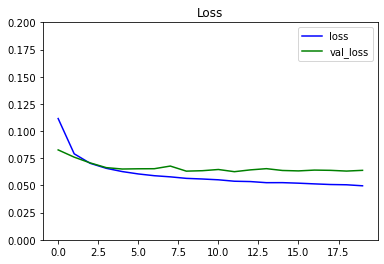

In [35]:
def plot_metrics(history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()

plot_metrics(history, metric_name='loss', title="Loss", ylim=0.2)

In [36]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

You can see sample results for 10 pairs of items below.

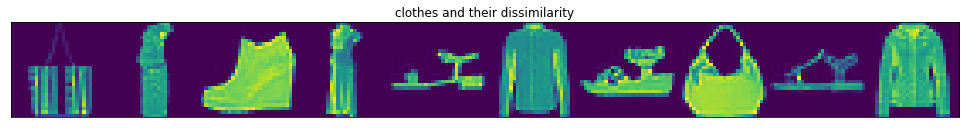

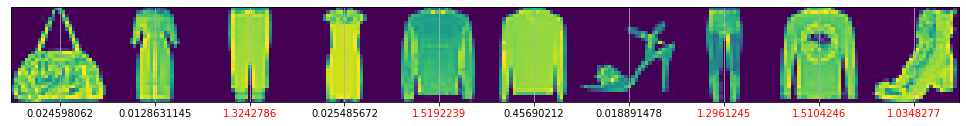

In [37]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_y[indexes], "clothes and their dissimilarity", 10)

## Application - Multiple Output Models using the Keras Functional API

In this section, we will use the Keras Functional API to train a model to predict two outputs, and it will use the **[Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)** from the **UCI machine learning repository**. It has separate datasets for red wine and white wine.

Normally, the wines are classified into one of the quality ratings specified in the attributes. In this exercise, you will combine the two datasets to predict the wine quality and whether the wine is red or white solely from the attributes. 

You will model wine quality estimations as a regression problem and wine type detection as a binary classification problem.

### Load Dataset

You will now load the dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

In [39]:
# URL of the white wine dataset
URI = './dataset/winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')

In [40]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])

8.8
9.1


In [42]:
# URL of the red wine dataset
URI = './dataset/winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')

In [43]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])

9.4
10.2


#### Concatenate the datasets

Next, concatenate the red and white wine dataframes.

In [44]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [45]:
df.alcohol[0]

9.4

In [46]:
df.alcohol[100]

9.5

In a real-world scenario, you should shuffle the data.

In [47]:
df = df.iloc[np.random.permutation(len(df))]

This will chart the quality of the wines.

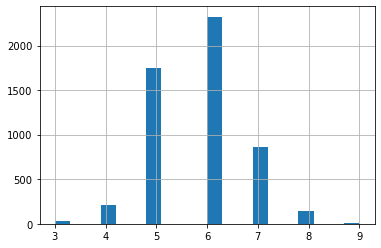

In [48]:
df['quality'].hist(bins=20);

#### Imbalanced data
You can see from the plot above that the wine quality dataset is imbalanced. 

- Since there are very few observations with quality equal to 3, 4, 8 and 9, you can drop these observations from your dataset. 
- You can do this by removing data belonging to all classes except those > 4 and < 8.

In [49]:
# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# reset index and drop the old one
df = df.reset_index(drop=True)

In [50]:
print(df.alcohol[0])
print(df.alcohol[100])

10.8
11.2


You can plot again to see the new range of data and quality

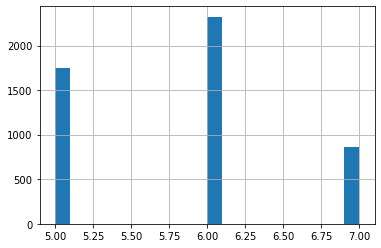

In [51]:
df['quality'].hist(bins=20);

#### Train Test Split

Next, you can split the datasets into training, test and validation datasets.
- The data frame should be split 80:20 into `train` and `test` sets.
- The resulting `train` should then be split 80:20 into `train` and `val` sets.
- The `train_test_split` parameter `test_size` takes a float value that ranges between 0. and 1, and represents the proportion of the dataset that is allocated to the test set.  The rest of the data is allocated to the training set.

In [52]:
# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state=1)

Here's where you can explore the training stats. You can pop the labels 'is_red' and 'quality' from the data as these will be used as the labels


In [53]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [54]:
train_stats

count        mean        std      min       25%  \
fixed acidity         3155.0    7.218051   1.314434  3.80000   6.40000   
volatile acidity      3155.0    0.343124   0.167368  0.08500   0.23000   
citric acid           3155.0    0.318659   0.146892  0.00000   0.25000   
residual sugar        3155.0    5.097195   4.603185  0.70000   1.80000   
chlorides             3155.0    0.057591   0.037349  0.00900   0.03800   
free sulfur dioxide   3155.0   30.198415  17.107398  2.00000  17.00000   
total sulfur dioxide  3155.0  114.670523  56.857906  6.00000  75.00000   
density               3155.0    0.994618   0.003055  0.98711   0.99222   
pH                    3155.0    3.224685   0.160749  2.74000   3.11000   
sulphates             3155.0    0.536076   0.147063  0.22000   0.44000   
alcohol               3155.0   10.520502   1.178784  8.00000   9.50000   

                           50%         75%        max  
fixed acidity           7.0000    7.700000   15.90000  
volatile acidity        0.2900    0.410000    1.33000  
citric acid             0.3100    0.390000    1.66000  
residual sugar          2.7000    7.600000   65.80000  
chlorides               0.0470    0.068000    0.61100  
free sulfur dioxide    28.0000   41.000000  128.00000  
total sulfur dioxide  116.0000  155.000000  303.00000  
density                 0.9948    0.996845    1.03898  
pH                      3.2200    3.330000    4.01000  
sulphates               0.5100    0.600000    1.62000  
alcohol                10.3000   11.300000   14.90000

#### Get the labels

The features and labels are currently in the same dataframe.
- You will want to store the label columns `is_red` and `quality` separately from the feature columns.  
- The following function, `format_output`, gets these two columns from the dataframe (it's given to you).
- `format_output` also formats the data into numpy arrays. 
- Please use the `format_output` and apply it to the `train`, `val` and `test` sets to get dataframes for the labels.

In [55]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [56]:
# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

Notice that after you get the labels, the `train`, `val` and `test` dataframes no longer contain the label columns, and contain just the feature columns.
- This is because you used `.pop` in the `format_output` function.

In [57]:
train.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
225             6.4              0.26         0.25           10.70      0.046   
3557            7.3              0.22         0.40           14.75      0.042   
3825            6.8              0.16         0.29           10.40      0.046   
1740            6.6              0.16         0.57            1.10      0.130   
1221            6.9              0.28         0.41            1.40      0.016   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
225                  66.0                 179.0  0.99606  3.17       0.55   
3557                 44.5                 129.5  0.99980  3.36       0.41   
3825                 59.0                 143.0  0.99518  3.20       0.40   
1740                 58.0                 140.0  0.99270  3.12       0.39   
1221                  6.0                  55.0  0.98876  3.16       0.40   

      alcohol  
225       9.9  
3557      9.1  
3825     10.8  
1740      9.3  
1221     13.4

#### Normalize the data 

Next, you can normalize the data, x, using the formula:

$$x_{norm} = \frac{x - \mu}{\sigma}$$

- The `norm` function is defined for you.
- Please apply the `norm` function to normalize the dataframes that contains the feature columns of `train`, `val` and `test` sets.

In [58]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [59]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

### Define the Model

Define the model using the functional API. The base model will be 2 `Dense` layers of 128 neurons each, and have the `'relu'` activation.
- Check out the documentation for [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [60]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation='relu')(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation='relu')(x)
    return x

### Define output layers of the model

You will add output layers to the base model. 
- The model will need two outputs.

One output layer will predict wine quality, which is a numeric value.
- Define a `Dense` layer with 1 neuron.
- Since this is a regression output, the activation can be left as its default value `None`.

The other output layer will predict the wine type, which is either red `1` or not red `0` (white).
- Define a `Dense` layer with 1 neuron.
- Since there are two possible categories, you can use a sigmoid activation for binary classification.

Define the `Model`
- Define the `Model` object, and set the following parameters:
  - `inputs`: pass in the inputs to the model as a list.
  - `outputs`: pass in a list of the outputs that you just defined: wine quality, then wine type.
  - **Note**: please list the wine quality before wine type in the outputs, as this will affect the calculated loss if you choose the other order.

In [61]:
def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])

    return model

### Compiling the Model

Next, compile the model. When setting the loss parameter of `model.compile`, you're setting the loss for each of the two outputs (wine quality and wine type).

To set more than one loss, use a dictionary of key-value pairs.
- You can look at the docs for the losses [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions).
    - **Note**: For the desired spelling, please look at the "Functions" section of the documentation and not the "classes" section on that same page.
- wine_type: Since you will be performing binary classification on wine type, you should use the binary crossentropy loss function for it.  Please pass this in as a string.  
  - **Hint**, this should be all lowercase.  In the documentation, you'll see this under the "Functions" section, not the "Classes" section.
- wine_quality: since this is a regression output, use the mean squared error.  Please pass it in as a string, all lowercase.
  - **Hint**: You may notice that there are two aliases for mean squared error.  Please use the shorter name.


You will also set the metric for each of the two outputs.  Again, to set metrics for two or more outputs, use a dictionary with key value pairs.
- The metrics documentation is linked [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).
- For the wine type, please set it to accuracy as a string, all lowercase.
- For wine quality, please use the root mean squared error.  Instead of a string, you'll set it to an instance of the class [RootMeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError), which belongs to the tf.keras.metrics module.

In [62]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mean_squared_error'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )

### Training the Model

Fit the model to the training inputs and outputs. 
- Check the documentation for [model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).
- Remember to use the normalized training set as inputs. 
- For the validation data, please use the normalized validation set.

In [63]:
history = model.fit(x=norm_train_X, y=train_Y,
                    epochs = 40, validation_data=(norm_val_X, val_Y))

Epoch 1/40
99/99 [==============================] - 2s 12ms/step - loss: 23.0054 - wine_quality_loss: 22.3884 - wine_type_loss: 0.6170 - wine_quality_root_mean_squared_error: 4.7316 - wine_type_accuracy: 0.7423 - val_loss: 15.7310 - val_wine_quality_loss: 15.1511 - val_wine_type_loss: 0.5800 - val_wine_quality_root_mean_squared_error: 3.8924 - val_wine_type_accuracy: 0.7465
Epoch 2/40
99/99 [==============================] - 1s 11ms/step - loss: 9.8386 - wine_quality_loss: 9.2897 - wine_type_loss: 0.5490 - wine_quality_root_mean_squared_error: 3.0479 - wine_type_accuracy: 0.7385 - val_loss: 5.6479 - val_wine_quality_loss: 5.1287 - val_wine_type_loss: 0.5191 - val_wine_quality_root_mean_squared_error: 2.2647 - val_wine_type_accuracy: 0.7452
Epoch 3/40
99/99 [==============================] - 1s 11ms/step - loss: 3.8056 - wine_quality_loss: 3.3435 - wine_type_loss: 0.4621 - wine_quality_root_mean_squared_error: 1.8285 - wine_type_accuracy: 0.7594 - val_loss: 2.8688 - val_wine_quality_los

In [64]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 4ms/step - loss: 0.4327 - wine_quality_loss: 0.3909 - wine_type_loss: 0.0418 - wine_quality_root_mean_squared_error: 0.6252 - wine_type_accuracy: 0.9937

loss: 0.43266481161117554
wine_quality_loss: 0.39088746905326843
wine_type_loss: 0.04177739843726158
wine_quality_rmse: 0.6252099275588989
wine_type_accuracy: 0.9936628937721252


### Analyze the Model Performance

Note that the model has two outputs. The output at index 0 is quality and index 1 is wine type

So, round the quality predictions to the nearest integer.

In [65]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [66]:
quality_pred[0]

array([6.014229], dtype=float32)

### Plot Utilities

We define a few utilities to visualize the model performance.

In [72]:
def plot_metrics(history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [70]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [71]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

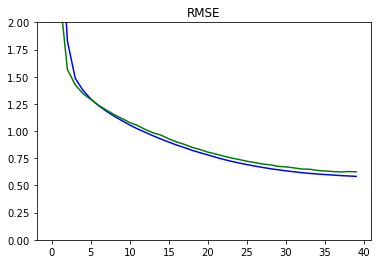

In [73]:
plot_metrics(history, 'wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

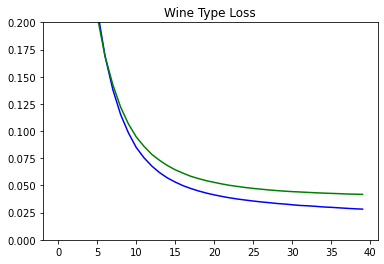

In [74]:
plot_metrics(history, 'wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix

Plot the confusion matrices for wine type. You can see that the model performs well for prediction of wine type from the confusion matrix and the loss metrics.

C:\Users\kcsgo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
C:\Users\kcsgo\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


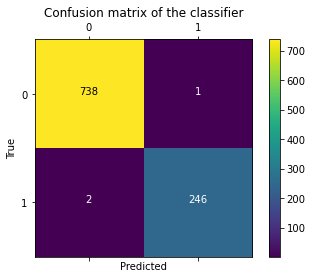

In [75]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

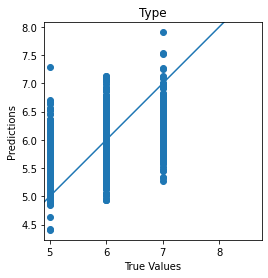

In [76]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')